# AI502/KSE527, Homework 01

This file is made by Jaehoon Oh, which is modified based on https://github.com/floydhub/regression

In [1]:
import torch
import torch.nn as nn
import torch.utils.data

In [2]:
POLY_DEGREE = 4
torch.manual_seed(2020)
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

In [3]:
def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = ''
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

In [4]:
print('==> The real function you should approximate:\t' + poly_desc(W_target.view(-1), b_target))

==> The real function you should approximate:	+6.19 x^4 -4.80 x^3 +7.71 x^2 -2.04 x^1 +4.40


---

In [5]:
def make_features(x):
    """Builds features i.e. a matrix with columns [x^4, x^3, x^2, x^1]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** (POLY_DEGREE+1-i) for i in range(1, POLY_DEGREE+1)], 1)

In [6]:
def f(x):
    """Approximated function."""
    return x.mm(W_target) + b_target[0]

In [7]:
def get_dataset(dataset_size):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(dataset_size)
    x = make_features(random)
    y = f(x)
    dataset = list(zip(x, y))
    return dataset


In [8]:
dataset = get_dataset(200) # you can make as many as dataset as you want
print(dataset)

[(tensor([6.2834, 3.9687, 2.5067, 1.5832]), tensor([40.3072])), (tensor([ 1.8405, -1.5802,  1.3566, -1.1648]), tensor([36.2081])), (tensor([0.4151, 0.5172, 0.6443, 0.8027]), tensor([7.8166])), (tensor([ 0.8594, -0.8926,  0.9270, -0.9628]), tensor([23.1140])), (tensor([ 6.2216, -3.9393,  2.4943, -1.5793]), tensor([84.2530])), (tensor([ 0.0022, -0.0100,  0.0464, -0.2155]), tensor([5.2617])), (tensor([0.0490, 0.1042, 0.2215, 0.4706]), tensor([4.9531])), (tensor([0.0002, 0.0018, 0.0149, 0.1220]), tensor([4.2615])), (tensor([0.2548, 0.3587, 0.5048, 0.7105]), tensor([6.6989])), (tensor([ 0.0003, -0.0021,  0.0162, -0.1274]), tensor([4.7996])), (tensor([14.0503, -7.2571,  3.7484, -1.9361]), tensor([159.0084])), (tensor([0.4918, 0.5873, 0.7013, 0.8374]), tensor([8.3228])), (tensor([4.4075e-09, 5.4094e-07, 6.6389e-05, 8.1480e-03]), tensor([4.3868])), (tensor([ 0.0005, -0.0034,  0.0226, -0.1504]), tensor([4.9036])), (tensor([0.0005, 0.0035, 0.0231, 0.1521]), tensor([4.2574])), (tensor([17.5733, -

---

In [25]:
num_epochs =30
batch_size = 50
learning_rate = 0.1
criterion = nn.SmoothL1Loss()

In [26]:
dataset_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

---

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(W_target.size(0), 1)
        
        # For fixing the initial weights and bias
        self.fc.weight.data.fill_(0.)
        self.fc.bias.data.fill_(0.)
        
    def forward(self, x):
        output = self.fc(x)
        return output

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on CPU")

running on GPU


---

In [29]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

MODEL_NAME = f"model-{int(time.time())}"
print(MODEL_NAME)


def fit(model,loader,criterion,learning_rate,num_epochs):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    with open("model_0.1.log", "a") as f:
        
        for epoch in range(num_epochs):
            for i, data in enumerate(loader):
                if torch.cuda.is_available():
                    x = data[0].type(torch.FloatTensor).cuda()
                    y = data[1].type(torch.FloatTensor).cuda()
                else:
                    x = data[0].type(torch.FloatTensor)
                    y = data[1].type(torch.FloatTensor)   

                y_hat = model(x)
                loss = criterion(y_hat, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                print(y)
                print(y_hat)
                
        y = y.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        fig = plt.figure() #for multiple figurs, for one thing just use plt.plot(times, accuracies) and plt.show()
        plt.figure(figsize=(20,20))
        plt.rcParams.update({'font.size': 22})


        #define axis, each axis is a graph
        ax1 = plt.subplot2grid((2,1), (0,0))
        #ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

        ax1.plot(y, label="actual")
        ax1.plot(y_hat, label="learned")
        ax1.legend(loc=2)

        #ax2.plot(x, LF, label="learned")
        #ax2.legend(loc=2)

        plt.show()

                #f.write(f"{MODEL_NAME}, {epoch}, {round(time.time(),3)},{round(float(loss), 4)}, {x}, {y}, {y_hat}\n")

model-1585898579


---

In [30]:
net = Net().cuda() if torch.cuda.is_available() else Net()
print('==> Initial function:\t' + poly_desc(net.fc.weight.data.view(-1), net.fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

==> Initial function:	+0.00 x^4 +0.00 x^3 +0.00 x^2 +0.00 x^1 +0.00
==> Actual function:	+6.19 x^4 -4.80 x^3 +7.71 x^2 -2.04 x^1 +4.40


tensor([[   8.4094],
        [   4.7107],
        [  31.9645],
        [1051.5096],
        [   5.0686],
        [  35.2099],
        [   5.4829],
        [ 108.0183],
        [   4.2702],
        [  17.9107],
        [   4.6641],
        [  19.1601],
        [  23.1165],
        [  37.3611],
        [  41.2954],
        [  42.8720],
        [   6.5046],
        [   4.7148],
        [   4.4717],
        [   6.0027],
        [   5.3967],
        [  16.9864],
        [ 151.8661],
        [  29.6524],
        [   4.5634],
        [   7.1304],
        [   7.1312],
        [   4.6442],
        [  39.1479],
        [   4.2633],
        [   5.9436],
        [ 190.8159],
        [  98.1272],
        [  57.3378],
        [   4.2608],
        [   5.0786],
        [  11.2999],
        [   9.7235],
        [   6.9936],
        [  38.2754],
        [   5.6253],
        [  12.7118],
        [  17.7243],
        [   4.4503],
        [   4.6253],
        [   4.7996],
        [   7.3454],
        [   5

        [  36.1144]], device='cuda:0')
tensor([[ 25.2607],
        [  0.4197],
        [  0.4302],
        [  1.2816],
        [  1.0316],
        [  0.4693],
        [  3.3015],
        [  1.4682],
        [  1.6002],
        [  0.4010],
        [  0.7115],
        [  0.4856],
        [ 22.0456],
        [  3.8098],
        [  0.4180],
        [  0.4450],
        [  0.4826],
        [  0.7687],
        [ 14.4674],
        [  1.3200],
        [ 27.2170],
        [  2.2737],
        [  8.1134],
        [  0.4164],
        [  0.4392],
        [  2.0180],
        [  0.4069],
        [  1.0152],
        [  1.6017],
        [  0.4023],
        [  1.1639],
        [  0.4084],
        [  0.5116],
        [  0.8647],
        [  0.4506],
        [  5.4111],
        [  0.6262],
        [176.0582],
        [  0.9708],
        [  0.4096],
        [  0.4622],
        [  0.4631],
        [  0.7770],
        [  0.6364],
        [  0.5133],
        [  0.4012],
        [  0.5434],
        [  0.4189],
 

        [ 12.2172]], device='cuda:0')
tensor([[ 2.0303],
        [ 0.8168],
        [ 0.8233],
        [ 3.1864],
        [ 2.6400],
        [ 0.8814],
        [ 0.9753],
        [ 0.9643],
        [ 2.5980],
        [ 0.9385],
        [ 0.8901],
        [44.1763],
        [ 5.6782],
        [ 0.8170],
        [ 1.2911],
        [ 9.0634],
        [ 1.0868],
        [73.5429],
        [ 3.4340],
        [ 0.8083],
        [ 3.2432],
        [ 0.8096],
        [ 0.8023],
        [ 0.9129],
        [ 0.9083],
        [ 0.9186],
        [ 0.8002],
        [ 4.9667],
        [ 0.8615],
        [19.3615],
        [11.6648],
        [ 6.7916],
        [ 0.8379],
        [ 0.8502],
        [ 2.5631],
        [ 1.0232],
        [ 3.2003],
        [ 4.3713],
        [ 4.7859],
        [ 6.2495],
        [ 1.0293],
        [ 0.8034],
        [51.2895],
        [ 2.3860],
        [ 0.8120],
        [ 1.3980],
        [ 0.8118],
        [ 3.2034],
        [18.6775],
        [ 4.5474]], device='cud

        [24.6115]], device='cuda:0')
tensor([[ 1.2051],
        [ 1.2124],
        [63.3637],
        [ 1.5349],
        [ 1.6155],
        [ 3.5789],
        [19.4313],
        [ 1.5399],
        [ 1.2069],
        [ 4.1730],
        [ 1.5623],
        [ 9.3743],
        [ 5.2455],
        [ 5.9868],
        [ 2.3767],
        [ 4.0006],
        [ 1.2577],
        [40.4813],
        [37.4768],
        [24.3403],
        [ 3.3258],
        [ 1.2518],
        [ 1.5862],
        [ 1.2590],
        [ 1.2568],
        [ 3.5315],
        [57.3643],
        [ 1.2009],
        [36.0906],
        [ 1.2354],
        [ 2.0970],
        [ 7.3215],
        [ 1.4477],
        [ 6.0541],
        [ 1.4290],
        [ 1.3230],
        [10.1875],
        [ 4.9920],
        [17.4972],
        [ 1.5355],
        [ 1.2288],
        [25.7021],
        [22.2092],
        [ 6.2004],
        [75.7820],
        [ 6.1889],
        [ 6.5569],
        [ 1.3866],
        [ 3.0416],
        [ 6.7076]], device='cuda

        [  10.5226]], device='cuda:0')
tensor([[  8.0268],
        [  1.6240],
        [  1.8259],
        [ 21.6443],
        [  3.0403],
        [ 13.5833],
        [  1.7004],
        [  3.1690],
        [ 14.6460],
        [  1.9505],
        [  1.6542],
        [  2.1149],
        [ 19.1858],
        [  1.6035],
        [ 34.2694],
        [  1.6068],
        [  7.9824],
        [160.6724],
        [ 88.1823],
        [  1.9053],
        [  3.8806],
        [  1.7381],
        [  8.2518],
        [108.8681],
        [  2.0587],
        [  6.3728],
        [  1.6219],
        [ 27.7333],
        [ 20.1637],
        [  2.5458],
        [  9.0947],
        [ 16.1665],
        [  6.4006],
        [  4.7719],
        [  2.0838],
        [  4.0607],
        [  8.7426],
        [ 56.0180],
        [  1.6580],
        [ 29.6123],
        [  4.2620],
        [ 53.9751],
        [ 18.5822],
        [  3.6625],
        [  1.6657],
        [  1.6421],
        [ 32.4537],
        [704.2327],
 

        [  9.7235]], device='cuda:0')
tensor([[  2.0176],
        [ 58.4427],
        [  4.9438],
        [  4.6031],
        [  2.1680],
        [ 28.2422],
        [  2.4100],
        [ 10.8550],
        [  5.6598],
        [  6.2778],
        [193.6102],
        [  2.2544],
        [ 14.3296],
        [  3.1792],
        [  5.3921],
        [126.4101],
        [ 18.1033],
        [  2.0576],
        [  3.8125],
        [  2.8192],
        [  1.9582],
        [ 30.2362],
        [  8.7463],
        [  2.5149],
        [  6.7378],
        [  2.2874],
        [  1.9835],
        [ 10.7246],
        [ 43.4144],
        [  2.0254],
        [  2.9253],
        [  2.1442],
        [ 21.0884],
        [ 25.4263],
        [  2.0348],
        [ 14.4025],
        [  9.9094],
        [  1.9684],
        [  2.1251],
        [ 48.8104],
        [ 11.6867],
        [ 10.4884],
        [  2.2811],
        [  2.1290],
        [  1.9720],
        [ 58.9973],
        [  3.8925],
        [ 62.0990],
  

        [  4.3868]], device='cuda:0')
tensor([[  2.8489],
        [  2.2961],
        [ 72.7985],
        [  7.3340],
        [  2.7994],
        [ 28.0673],
        [  2.6808],
        [  2.4627],
        [  2.5946],
        [ 18.9006],
        [  5.5322],
        [  2.7378],
        [  5.9897],
        [  4.3952],
        [ 22.0081],
        [  2.7273],
        [  2.4258],
        [  2.3173],
        [ 31.6037],
        [  4.4930],
        [  2.4234],
        [  2.3624],
        [ 11.4840],
        [  2.3142],
        [ 29.5090],
        [136.5221],
        [  4.0569],
        [  2.3765],
        [  5.0449],
        [ 44.2647],
        [ 55.2850],
        [  4.8976],
        [  2.3437],
        [  5.6014],
        [ 10.9310],
        [  2.2846],
        [190.9655],
        [  2.3276],
        [ 14.9491],
        [ 66.1130],
        [ 12.7695],
        [  3.7558],
        [ 43.3511],
        [  4.5779],
        [ 20.7761],
        [  2.4639],
        [ 27.4705],
        [  2.2871],
  

        [ 27.0511]], device='cuda:0')
tensor([[ 13.0212],
        [  3.2010],
        [  2.7024],
        [ 21.2906],
        [  5.0376],
        [ 10.5313],
        [  2.6362],
        [  2.7801],
        [ 61.5850],
        [ 73.4797],
        [ 12.6855],
        [  2.6210],
        [  7.2314],
        [  2.5965],
        [  6.2035],
        [  3.0462],
        [  2.6155],
        [  2.5960],
        [ 15.3250],
        [  3.5560],
        [ 13.0230],
        [ 11.1316],
        [ 23.3755],
        [150.8501],
        [ 80.8416],
        [  3.3953],
        [  2.6073],
        [  2.9499],
        [  2.7199],
        [ 10.6211],
        [  6.2805],
        [  5.8798],
        [ 10.2440],
        [  2.7321],
        [  2.6051],
        [  2.6198],
        [  2.7331],
        [ 25.4627],
        [  8.1494],
        [  8.9634],
        [ 11.2147],
        [  4.9002],
        [  3.3840],
        [  2.7291],
        [  5.0385],
        [  3.9481],
        [213.8114],
        [  4.6085],
  

        [   4.2624]], device='cuda:0')
tensor([[   6.4301],
        [   2.9164],
        [ 161.7031],
        [   3.3599],
        [  19.6390],
        [   6.5226],
        [   5.9658],
        [   9.7632],
        [  14.1696],
        [ 195.6940],
        [  30.5744],
        [  67.6702],
        [   4.1304],
        [   3.3238],
        [   2.8830],
        [  30.8914],
        [   3.1782],
        [   2.8863],
        [   2.9516],
        [  77.8022],
        [   2.9604],
        [ 164.7874],
        [   5.9303],
        [   3.1730],
        [   3.0982],
        [   7.7380],
        [   3.1369],
        [  10.6968],
        [  11.8883],
        [  11.3872],
        [  14.5421],
        [   2.8915],
        [ 229.4958],
        [   5.0089],
        [   3.1830],
        [  28.7298],
        [  46.6236],
        [   5.8223],
        [   4.7754],
        [   3.2718],
        [   8.1232],
        [   8.5089],
        [  41.1297],
        [   5.0623],
        [   4.8805],
        [  12.45

        [  4.3044]], device='cuda:0')
tensor([[  3.8056],
        [  3.1611],
        [  3.1574],
        [  9.0322],
        [  3.3911],
        [  3.1608],
        [  3.4137],
        [ 14.8394],
        [ 14.4815],
        [ 11.9548],
        [ 37.5390],
        [  3.1795],
        [  4.9847],
        [  9.2135],
        [  7.8720],
        [  4.5253],
        [  6.1743],
        [  3.2609],
        [ 85.5671],
        [  3.2599],
        [  3.6711],
        [  3.9719],
        [  7.4055],
        [  3.8617],
        [ 32.3547],
        [  3.7844],
        [ 10.9396],
        [  3.2095],
        [  3.5255],
        [  8.5229],
        [  5.6616],
        [  3.3060],
        [  5.8699],
        [  6.2422],
        [  5.7521],
        [  5.2134],
        [159.3423],
        [  3.4826],
        [114.0058],
        [  3.1579],
        [ 78.7680],
        [ 40.9916],
        [  3.3871],
        [  4.3902],
        [  3.3223],
        [  4.7790],
        [  3.3915],
        [  3.4255],
  

        [  4.2674]], device='cuda:0')
tensor([[  4.4284],
        [  9.1868],
        [  3.6812],
        [ 40.3072],
        [  5.3800],
        [181.4084],
        [ 28.8188],
        [  4.4574],
        [  4.0247],
        [  3.4967],
        [  7.9654],
        [  6.3932],
        [  4.0838],
        [  3.7225],
        [  3.5910],
        [  3.4754],
        [  4.0422],
        [ 31.9791],
        [ 13.6485],
        [  6.0267],
        [  3.4719],
        [  3.9818],
        [ 68.9001],
        [  3.5175],
        [  5.9123],
        [ 61.9506],
        [  8.1895],
        [ 84.2062],
        [  3.5819],
        [ 26.3530],
        [  3.4658],
        [  3.4662],
        [  3.8226],
        [ 54.6472],
        [  3.5730],
        [  3.4732],
        [  3.8052],
        [ 20.9642],
        [  3.6570],
        [ 25.5222],
        [  4.0451],
        [  3.5334],
        [ 11.0070],
        [ 16.9490],
        [  4.7876],
        [  3.5894],
        [112.2857],
        [ 15.8110],
  

        [   4.5540]], device='cuda:0')
tensor([[   8.2522],
        [  30.1772],
        [  19.4459],
        [   4.6057],
        [   3.8441],
        [   3.9731],
        [  32.2325],
        [1097.9714],
        [   8.0056],
        [  39.1885],
        [   4.1656],
        [   3.7847],
        [   6.3163],
        [   6.2023],
        [   4.7554],
        [   9.4339],
        [  25.3941],
        [   6.5896],
        [   3.9657],
        [   5.6129],
        [   4.1771],
        [  37.3586],
        [   4.3272],
        [ 236.4748],
        [   3.7813],
        [   3.7818],
        [   5.4547],
        [   5.0201],
        [   5.2598],
        [  11.2972],
        [  43.4655],
        [  13.6435],
        [   3.8727],
        [  27.8371],
        [   3.7814],
        [  12.5928],
        [  26.4362],
        [  26.8239],
        [  42.2970],
        [   5.0203],
        [   4.0045],
        [   3.7984],
        [   4.8686],
        [   3.8306],
        [   4.1611],
        [   3.78

        [   7.8166]], device='cuda:0')
tensor([[ 171.2542],
        [   4.0456],
        [   8.1112],
        [  37.0820],
        [  14.0037],
        [  17.1504],
        [  24.3997],
        [   4.0993],
        [   4.0457],
        [   4.0469],
        [  25.2644],
        [  14.0041],
        [ 188.2641],
        [   4.0491],
        [   5.5245],
        [  22.4660],
        [   4.2011],
        [   5.6939],
        [ 166.3401],
        [   4.1425],
        [   4.3135],
        [   4.2216],
        [   5.9773],
        [   9.2770],
        [   4.0527],
        [ 105.9210],
        [   4.0827],
        [   4.4689],
        [  10.2510],
        [  13.3379],
        [1059.8633],
        [ 142.5634],
        [  40.7063],
        [   4.4842],
        [   6.6464],
        [  26.2217],
        [   4.2072],
        [   5.8594],
        [  88.0353],
        [   6.7185],
        [   4.0769],
        [  38.2088],
        [   4.6657],
        [   5.7478],
        [  17.9785],
        [  11.62

        [  6.5202]], device='cuda:0')
tensor([[  9.3996],
        [  6.5439],
        [  6.8400],
        [166.2692],
        [ 10.6353],
        [  4.7732],
        [  5.9615],
        [  5.2747],
        [141.8779],
        [  4.4878],
        [  4.3188],
        [  9.9177],
        [ 32.3727],
        [ 25.0827],
        [ 26.3159],
        [ 93.4226],
        [  4.7672],
        [  4.3124],
        [ 28.1125],
        [ 17.5673],
        [  5.4269],
        [ 19.9356],
        [  5.6772],
        [ 17.5404],
        [ 10.2074],
        [167.2714],
        [ 12.7433],
        [  4.8464],
        [  5.4115],
        [ 71.3147],
        [  4.5023],
        [  4.3528],
        [ 13.3067],
        [  4.4746],
        [  8.3360],
        [  5.7589],
        [ 14.0983],
        [ 92.0715],
        [ 13.4496],
        [ 11.0771],
        [  5.1883],
        [  4.3333],
        [  5.0343],
        [  5.6429],
        [  4.9154],
        [  6.9616],
        [ 86.2285],
        [  4.7227],
  

        [   4.8015]], device='cuda:0')
tensor([[  6.0614],
        [ 71.2972],
        [  4.9919],
        [  7.0189],
        [ 20.5163],
        [  4.7013],
        [  6.0373],
        [  4.5341],
        [ 53.2637],
        [  4.5332],
        [ 12.1142],
        [  4.5577],
        [  4.5360],
        [  7.1451],
        [  9.5841],
        [  5.2684],
        [  6.1619],
        [ 13.6652],
        [  4.5891],
        [  4.9066],
        [  4.5339],
        [  4.6040],
        [ 12.2686],
        [ 23.4574],
        [ 19.0060],
        [ 32.6758],
        [ 19.1057],
        [  6.6038],
        [ 27.6419],
        [  4.7840],
        [ 10.9893],
        [ 83.9055],
        [  4.6983],
        [  4.8868],
        [ 15.6848],
        [ 28.7208],
        [  5.9533],
        [  4.5333],
        [ 23.2301],
        [  4.9954],
        [  4.7170],
        [  4.9550],
        [ 19.5679],
        [ 14.0058],
        [ 36.9221],
        [998.9782],
        [ 32.0309],
        [  9.5082],
 

        [ 83.5114]], device='cuda:0')
tensor([[  6.3516],
        [ 97.3748],
        [  5.4915],
        [  4.8053],
        [  4.7359],
        [169.2072],
        [ 11.5310],
        [  4.7020],
        [  4.7420],
        [  5.3050],
        [  4.7302],
        [  6.0432],
        [ 20.0524],
        [  4.7022],
        [ 34.8282],
        [  8.7202],
        [  5.1056],
        [  8.3502],
        [  4.9442],
        [ 30.1248],
        [  6.4088],
        [ 26.5873],
        [ 20.0874],
        [ 14.4466],
        [  6.4046],
        [  5.5637],
        [  6.3557],
        [  4.7129],
        [  4.7307],
        [ 31.1483],
        [ 30.2198],
        [ 19.5110],
        [  5.8792],
        [ 25.3616],
        [  5.1673],
        [ 37.9030],
        [ 36.0828],
        [162.1977],
        [  4.8658],
        [  5.3817],
        [ 10.4076],
        [  4.7426],
        [  6.9079],
        [  4.9999],
        [  5.2024],
        [  4.7041],
        [ 24.8552],
        [  5.5359],
  

        [  6.0027]], device='cuda:0')
tensor([[ 15.1786],
        [  4.8634],
        [  5.2786],
        [ 31.4965],
        [  5.0648],
        [ 77.0257],
        [  4.8603],
        [  4.9719],
        [  5.1886],
        [  4.8842],
        [  4.8876],
        [  5.1648],
        [  4.8619],
        [  6.0068],
        [ 29.5903],
        [ 60.0815],
        [ 85.2148],
        [  4.9051],
        [ 11.8225],
        [ 54.2197],
        [  8.3428],
        [ 10.0233],
        [  4.8703],
        [ 34.6097],
        [ 30.4735],
        [  4.8612],
        [ 57.0577],
        [ 20.0240],
        [ 74.8308],
        [  5.3445],
        [  5.0837],
        [ 89.1875],
        [ 33.9356],
        [ 19.5671],
        [  5.2565],
        [ 18.7106],
        [ 16.7884],
        [  9.1736],
        [ 28.6309],
        [  5.7663],
        [  7.4163],
        [235.3717],
        [  4.8602],
        [  4.9641],
        [  8.4563],
        [ 33.0881],
        [  6.5374],
        [  6.3992],
  

        [ 18.9617]], device='cuda:0')
tensor([[  5.4783],
        [  6.3226],
        [  4.9746],
        [  6.1510],
        [ 15.2809],
        [ 16.8478],
        [  5.3256],
        [  6.9245],
        [ 16.5109],
        [  5.8539],
        [101.8166],
        [ 13.0956],
        [ 41.6594],
        [ 55.9259],
        [ 27.3371],
        [  5.6410],
        [ 14.6543],
        [ 79.4979],
        [ 58.8588],
        [ 10.1282],
        [  5.4211],
        [ 12.2996],
        [  4.9760],
        [ 29.1543],
        [ 31.2126],
        [ 11.5789],
        [  5.8698],
        [  6.3741],
        [  5.2757],
        [ 24.7836],
        [ 16.3525],
        [165.2366],
        [  4.9768],
        [ 78.1470],
        [186.1326],
        [ 11.1171],
        [  5.8657],
        [  6.5964],
        [  5.4698],
        [  6.2096],
        [ 14.9744],
        [  6.7015],
        [  5.0027],
        [  5.1558],
        [  4.9745],
        [ 35.7214],
        [  6.1479],
        [  5.0427],
  

        [  19.5507]], device='cuda:0')
tensor([[   5.1467],
        [   6.7723],
        [   5.0466],
        [  32.9047],
        [   5.3627],
        [   5.0339],
        [   5.1928],
        [   8.9394],
        [   5.0373],
        [  33.5906],
        [ 176.0508],
        [   5.5865],
        [1071.9113],
        [ 103.3624],
        [   6.1537],
        [  87.7890],
        [   5.0409],
        [  11.2973],
        [  15.9429],
        [   5.1044],
        [  29.9485],
        [  90.7572],
        [  10.7095],
        [   5.0623],
        [  34.5449],
        [  11.6745],
        [1042.4055],
        [  10.3613],
        [   5.1210],
        [  36.1121],
        [  20.1087],
        [   5.3926],
        [   9.9203],
        [  21.0422],
        [   5.9783],
        [  25.9087],
        [   5.2584],
        [  33.7432],
        [  36.5104],
        [  62.2516],
        [  30.9386],
        [   5.2764],
        [   5.0952],
        [  35.4179],
        [   6.4713],
        [  14.36

        [  7.8166]], device='cuda:0')
tensor([[  5.1377],
        [ 20.9069],
        [176.6876],
        [ 14.0465],
        [ 16.8881],
        [  5.7541],
        [  5.1457],
        [  5.5532],
        [ 38.8226],
        [  6.5841],
        [  5.3327],
        [163.2038],
        [  5.3367],
        [ 89.6554],
        [  7.6947],
        [ 40.1957],
        [  6.3605],
        [ 33.6122],
        [154.0388],
        [ 11.5499],
        [ 55.6605],
        [ 58.5503],
        [  6.7819],
        [  5.3131],
        [ 26.2202],
        [ 78.9293],
        [ 15.2064],
        [ 29.2496],
        [  5.1377],
        [ 23.2869],
        [  5.1893],
        [  5.4974],
        [  5.4947],
        [ 11.3895],
        [ 14.3511],
        [101.1166],
        [  6.8240],
        [  5.2555],
        [  5.1387],
        [  5.1464],
        [ 14.6827],
        [ 11.8266],
        [  5.3565],
        [ 15.7989],
        [ 15.9605],
        [ 20.5497],
        [  5.1394],
        [  9.7710],
  

        [  5.1042]], device='cuda:0')
tensor([[  6.2411],
        [  8.7846],
        [  7.2309],
        [  6.5756],
        [  5.1776],
        [ 18.2378],
        [ 39.6572],
        [ 23.6143],
        [  5.4319],
        [ 20.3638],
        [  5.2828],
        [  5.1670],
        [ 10.2375],
        [  7.4500],
        [ 53.4444],
        [  5.7574],
        [174.7512],
        [  5.1721],
        [  6.1807],
        [  5.4458],
        [ 26.4653],
        [  7.0154],
        [  5.6668],
        [ 11.5421],
        [  6.9252],
        [  5.2042],
        [ 17.2188],
        [ 36.9542],
        [  6.8099],
        [  5.1813],
        [  5.3576],
        [101.8182],
        [ 35.3672],
        [ 42.4214],
        [156.5069],
        [ 16.1301],
        [  6.0685],
        [ 28.1819],
        [  5.4034],
        [ 78.5230],
        [  5.7456],
        [  5.5162],
        [ 25.2868],
        [  5.5378],
        [  6.6752],
        [ 44.6041],
        [  5.1666],
        [  7.1190],
  

        [181.2083]], device='cuda:0')
tensor([[ 31.9459],
        [  9.2866],
        [ 32.8691],
        [ 13.0031],
        [ 11.8904],
        [  5.3060],
        [ 23.9270],
        [  5.2503],
        [  8.7340],
        [  6.9345],
        [ 18.4474],
        [  9.2600],
        [  6.5319],
        [ 16.7269],
        [ 22.2729],
        [  5.2135],
        [  5.2510],
        [ 17.2621],
        [  6.9916],
        [  5.5963],
        [  5.4063],
        [  5.4095],
        [ 12.2651],
        [ 78.6671],
        [ 20.2899],
        [  5.7276],
        [154.2305],
        [  5.2136],
        [  5.2207],
        [ 15.9365],
        [ 13.1006],
        [  5.6073],
        [  5.2140],
        [  5.2133],
        [  5.4099],
        [177.3453],
        [ 92.1245],
        [ 31.3761],
        [  5.6707],
        [  9.4132],
        [  7.4636],
        [  7.2215],
        [ 74.7380],
        [  6.5729],
        [  5.4886],
        [ 17.2495],
        [100.3878],
        [  5.2436],
  

        [  4.4110]], device='cuda:0')
tensor([[  5.5045],
        [ 10.3082],
        [ 27.0122],
        [  5.2409],
        [  7.5181],
        [176.2453],
        [  5.2408],
        [  5.6485],
        [ 23.5477],
        [ 96.6180],
        [  5.4391],
        [ 24.7338],
        [  5.4434],
        [154.8439],
        [ 11.0947],
        [ 37.3256],
        [  5.3631],
        [ 11.0347],
        [ 32.1057],
        [  5.2423],
        [  5.9423],
        [  9.6979],
        [  6.9547],
        [  6.8142],
        [ 19.8545],
        [ 17.9374],
        [  5.7141],
        [ 24.0145],
        [ 10.2347],
        [  6.6006],
        [ 29.1243],
        [  5.4926],
        [ 10.1876],
        [173.1977],
        [  5.3255],
        [ 78.5450],
        [  5.2791],
        [  5.5157],
        [ 42.7612],
        [ 78.5008],
        [  6.4258],
        [  5.9188],
        [  7.3057],
        [  6.9541],
        [  5.2402],
        [100.0789],
        [  6.5589],
        [ 11.8050],
  

        [  12.7118]], device='cuda:0')
tensor([[   5.4682],
        [   7.0675],
        [   9.5119],
        [  12.5644],
        [  13.9178],
        [  79.2480],
        [  64.1188],
        [  19.7452],
        [   5.4622],
        [  22.7171],
        [   5.6768],
        [   7.1210],
        [   5.2887],
        [   5.8910],
        [  89.7125],
        [   6.3662],
        [  37.0175],
        [1029.3845],
        [  14.7411],
        [  34.4673],
        [   5.2570],
        [   5.6690],
        [  17.6468],
        [   5.6736],
        [   5.7909],
        [  28.0899],
        [   6.2579],
        [   5.9521],
        [  10.3086],
        [  22.5178],
        [   5.5464],
        [   9.6423],
        [  21.3601],
        [  15.8840],
        [  27.3253],
        [  14.8797],
        [  20.2899],
        [   7.2326],
        [   5.7008],
        [  13.4260],
        [   6.6955],
        [   6.2652],
        [   5.9446],
        [  37.0233],
        [   6.6525],
        [  18.15

        [  6.6989]], device='cuda:0')
tensor([[ 17.9081],
        [  6.2981],
        [ 40.3243],
        [  6.3796],
        [180.9515],
        [ 90.3540],
        [  5.6345],
        [  5.2951],
        [ 17.3678],
        [ 27.9167],
        [  7.2934],
        [  5.5591],
        [  8.3153],
        [ 19.1453],
        [  5.2815],
        [  7.4416],
        [  7.2880],
        [ 40.4651],
        [  5.5813],
        [ 23.0886],
        [  5.3582],
        [ 11.3167],
        [187.6829],
        [ 26.1933],
        [  9.6260],
        [ 15.2781],
        [ 10.9475],
        [  5.2805],
        [  6.1261],
        [  5.3049],
        [ 12.6741],
        [ 46.2026],
        [ 65.2987],
        [  5.2831],
        [  5.9347],
        [ 58.4483],
        [ 94.4357],
        [ 29.6904],
        [  5.4349],
        [  5.2825],
        [  7.1037],
        [  5.8447],
        [  5.7259],
        [ 86.4161],
        [  5.5331],
        [ 15.6246],
        [  6.4092],
        [  5.3425],
  

        [ 24.1801]], device='cuda:0')
tensor([[  5.3598],
        [ 13.8562],
        [ 11.5395],
        [ 38.5812],
        [  7.4883],
        [  7.6144],
        [  9.1462],
        [ 25.2671],
        [ 15.9322],
        [105.3152],
        [  8.2632],
        [ 89.5375],
        [ 34.7844],
        [  6.2326],
        [106.7845],
        [191.9999],
        [ 57.7759],
        [  5.2863],
        [  5.4599],
        [  5.5502],
        [  5.2262],
        [  8.2191],
        [  5.4557],
        [  8.1448],
        [  9.8847],
        [  5.2593],
        [  5.2408],
        [  7.7156],
        [  5.7497],
        [  5.7063],
        [ 10.5868],
        [ 10.6395],
        [  5.2578],
        [  5.2262],
        [  6.8714],
        [  5.2669],
        [ 35.5590],
        [  6.3023],
        [  6.3870],
        [  5.2309],
        [ 12.4164],
        [  7.8242],
        [  5.2648],
        [159.1086],
        [102.4578],
        [  5.9103],
        [ 22.2228],
        [  7.1382],
  

        [  6.9256]], device='cuda:0')
tensor([[  5.6620],
        [  5.5504],
        [  5.2232],
        [  5.2340],
        [  5.6783],
        [  7.2739],
        [ 33.7881],
        [ 17.1722],
        [ 40.0258],
        [ 77.4614],
        [ 44.9543],
        [  5.2345],
        [ 85.5028],
        [  7.1701],
        [  5.9263],
        [  7.0021],
        [ 23.6332],
        [  7.9030],
        [  5.6358],
        [ 25.9101],
        [ 23.5366],
        [  9.7374],
        [ 30.6577],
        [  6.7969],
        [ 22.2167],
        [ 32.7374],
        [  6.4276],
        [  6.1289],
        [  8.1662],
        [106.2035],
        [  5.3725],
        [  9.9223],
        [183.9355],
        [  5.2518],
        [ 10.7517],
        [ 21.7547],
        [  6.3964],
        [ 18.3353],
        [  7.2162],
        [  6.3156],
        [  5.2586],
        [ 41.0510],
        [ 12.2085],
        [ 13.9008],
        [  5.9787],
        [ 27.6143],
        [158.0492],
        [  5.6749],
  

        [  5.9993]], device='cuda:0')
tensor([[  7.3256],
        [ 10.6791],
        [  5.4324],
        [ 17.3370],
        [  6.4117],
        [  6.2981],
        [  6.6295],
        [ 13.9197],
        [  5.1845],
        [ 13.4832],
        [ 12.5973],
        [  6.8052],
        [ 15.2865],
        [  7.1513],
        [  6.7771],
        [ 44.6443],
        [  5.9820],
        [103.4740],
        [  6.7916],
        [  5.1883],
        [ 10.8027],
        [  6.1135],
        [  8.2146],
        [ 15.2257],
        [  5.1845],
        [  6.9992],
        [ 30.4100],
        [  5.4567],
        [  7.0403],
        [  5.1846],
        [  5.8096],
        [  5.5311],
        [ 14.4343],
        [  5.4700],
        [  5.4368],
        [  9.7983],
        [  7.2078],
        [ 86.7561],
        [ 95.0963],
        [ 82.9840],
        [  5.4277],
        [ 16.9216],
        [  5.2164],
        [  5.2149],
        [  6.3854],
        [  5.6538],
        [  5.1979],
        [ 22.2057],
  

        [  4.7996]], device='cuda:0')
tensor([[  8.2799],
        [ 20.9059],
        [ 14.0113],
        [  5.2171],
        [  5.6316],
        [ 44.8788],
        [  7.1982],
        [ 23.7374],
        [ 81.6752],
        [  5.8121],
        [  5.5206],
        [103.7774],
        [ 11.5853],
        [ 25.9731],
        [  6.3958],
        [ 11.6296],
        [  6.7471],
        [  5.4394],
        [  5.3319],
        [ 32.7828],
        [ 18.6248],
        [ 15.7353],
        [  5.3074],
        [ 53.7274],
        [ 18.4534],
        [ 28.8496],
        [  5.2046],
        [  5.4854],
        [ 34.7822],
        [  9.6959],
        [  7.6737],
        [  9.2466],
        [  5.2912],
        [  5.1722],
        [ 17.4633],
        [ 30.7194],
        [  5.5147],
        [ 95.3959],
        [ 30.7767],
        [  5.6398],
        [188.0167],
        [  6.1183],
        [  7.4220],
        [  9.2535],
        [ 17.8220],
        [  5.2012],
        [156.0914],
        [ 30.6089],
  

        [  7.3454]], device='cuda:0')
tensor([[178.5064],
        [103.7132],
        [  5.1245],
        [  5.1755],
        [  5.3961],
        [ 10.6823],
        [ 80.6509],
        [  5.3973],
        [ 38.8836],
        [ 20.2058],
        [ 13.9609],
        [  5.1242],
        [ 16.0246],
        [  7.7523],
        [ 17.3826],
        [ 15.2805],
        [ 12.4034],
        [  5.7944],
        [  5.1232],
        [  6.7641],
        [ 14.4851],
        [  5.1911],
        [ 24.5359],
        [  6.2709],
        [  5.4008],
        [ 34.4840],
        [  6.8240],
        [  7.8083],
        [  5.1234],
        [ 10.7413],
        [  7.7542],
        [  5.1236],
        [  7.6469],
        [ 13.5448],
        [ 17.8006],
        [  7.1652],
        [  6.2449],
        [ 38.7458],
        [  5.2483],
        [  6.9915],
        [ 34.6118],
        [ 13.0666],
        [  5.2015],
        [  5.1713],
        [  5.1516],
        [ 11.5949],
        [ 36.4415],
        [  6.3618],
  

<Figure size 432x288 with 0 Axes>

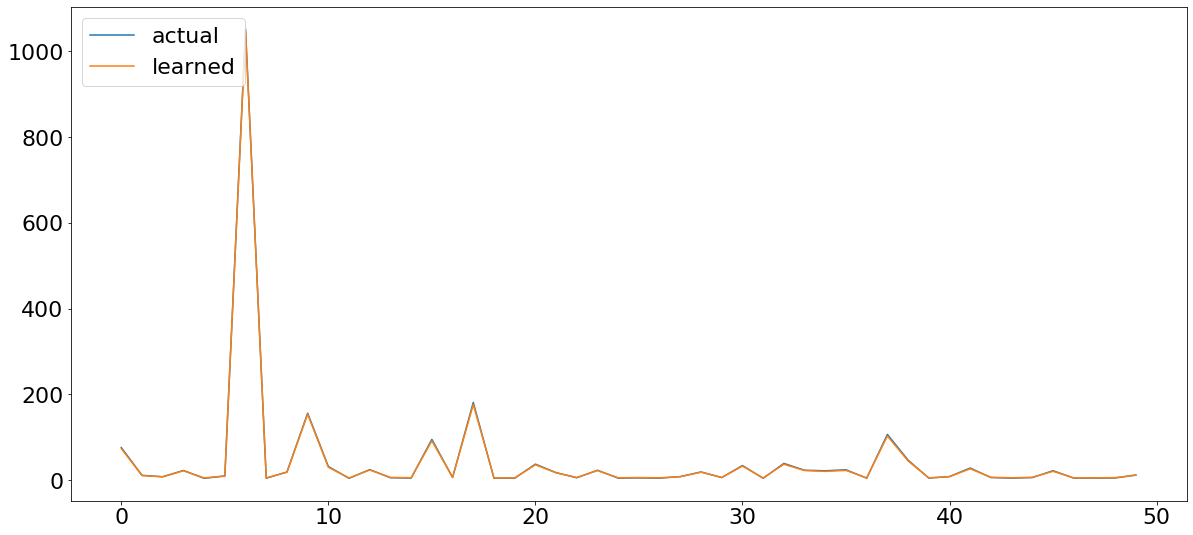

In [31]:
# train
fit(net,dataset_loader,criterion,learning_rate,num_epochs)


In [24]:
print('==> Learned function:\t' + poly_desc(net.fc.weight.data.view(-1), net.fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

==> Learned function:	+7.01 x^4 -4.66 x^3 +4.39 x^2 -1.57 x^1 +5.33
==> Actual function:	+6.19 x^4 -4.80 x^3 +7.71 x^2 -2.04 x^1 +4.40
